In [35]:
# Standard library
import os
from time import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed

# Data manipulation
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as pn

# Modeling and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import (RandomForestClassifier, VotingClassifier, 
                              StackingClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import log_loss, roc_auc_score, confusion_matrix

# Utility
from tqdm import tqdm



# First things first

lets understand what the data looks like. Get a feel for the columns and everything.

I will look for obvious errors or weirdness in the dataset

In [2]:
dat = pd.read_csv('../data/Douglas Lawton- DS Case Study/train.csv')

In [3]:
print(dat.columns)

Index(['customer_id', 'limit_bal', 'sex', 'education', 'marriage', 'age',
       'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_oct'],
      dtype='object')


In [4]:
dat.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,24001.0,NaN,NaN,NaN,12001.0,6928.636241,1.0,6001.0,12001.0,18001.0,24001.0
limit_bal,24001.0,NaN,NaN,NaN,8351.302029,6475.59245,500.0,2500.0,7000.0,12000.0,50000.0
sex,24001.0,NaN,NaN,NaN,1.604058,0.489062,1.0,1.0,2.0,2.0,2.0
education,24001.0,NaN,NaN,NaN,1.856839,0.792152,0.0,1.0,2.0,2.0,6.0
marriage,24001.0,NaN,NaN,NaN,1.551644,0.522663,0.0,1.0,2.0,2.0,3.0
age,24001.0,NaN,NaN,NaN,35.498438,9.222021,21.0,28.0,34.0,41.0,79.0
pay_1,24001.0,NaN,NaN,NaN,-0.015874,1.123554,-2.0,-1.0,0.0,0.0,8.0
pay_2,24001.0,NaN,NaN,NaN,-0.132119,1.199237,-2.0,-1.0,0.0,0.0,8.0
pay_3,24001.0,NaN,NaN,NaN,-0.166201,1.196802,-2.0,-1.0,0.0,0.0,8.0
pay_4,24001.0,NaN,NaN,NaN,-0.215824,1.17335,-2.0,-1.0,0.0,0.0,8.0


Most columns look reasonable. 


The more confusing columns are:
* `pay_` = history of payment
* `bill_amt` = amount of bill statement
* `pay_amt` = amount of previous payment

`pay_` is hot encoding with -1 = pay duly, 1 = delay for one month.... 9 = delay for 9 months or more. This is an interesting metric -- maybe I'll think further into this.

All have a temporal element to them with `1` in the column name denoting september to `6` in the column name denoting april. This implies some temporal autocorrelation between these columns. 

Since we are only concerned about predicting and not necessarily inference, this is less of a problem. But its good to keep in the back of my mind.

# Moving forward -- lets lock up 20% of our data as a internal testing dataset. 

I want to ensure that I have some dataset to compare with that is never touched by me or any algorithms to combat data leakage.

In [5]:
ground_truth_data_split =  dat.sample(frac=0.2, random_state=123) # Setting seed for reproducibility

ground_truth_data_split

,customer_id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_oct
3262,3263,4500,1.0,3.0,1.0,48.0,1.0,2.0,2.0,2.0,...,3350,3161.0,2968.0,85,200,80,80,75.0,204.0,no
7089,7090,4000,2.0,2.0,1.0,47.0,2.0,0.0,0.0,0.0,...,3172,2349.0,2393.0,155,183,153,100,100.0,121.0,yes
8472,8473,2500,1.0,3.0,2.0,23.0,2.0,0.0,0.0,0.0,...,543,469.0,472.0,75,75,15,25,25.0,5.0,yes
4761,4762,4000,1.0,1.0,2.0,43.0,0.0,0.0,0.0,0.0,...,3685,3716.0,3782.0,154,400,150,150,150.0,200.0,no
14539,14540,19500,2.0,1.0,1.0,42.0,0.0,0.0,0.0,0.0,...,2760,1485.0,-71.0,501,200,752,1000,0.0,504.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,7420,7500,2.0,1.0,2.0,29.0,-1.0,-1.0,-1.0,-1.0,...,798,463.0,1266.0,293,764,798,463,1266.0,367.0,no
18519,18520,5000,2.0,1.0,2.0,38.0,2.0,2.0,2.0,2.0,...,2014,2041.0,NaN,25,175,75,75,75.0,NaN,yes
18391,18392,13000,2.0,1.0,2.0,28.0,-2.0,-2.0,-2.0,-2.0,...,77,34.0,581.0,288,35,78,34,584.0,349.0,no
7192,7193,4000,2.0,2.0,1.0,52.0,1.0,2.0,2.0,2.0,...,3708,3400.0,2901.0,0,350,200,0,150.0,150.0,no


In [6]:
model_dat = dat.drop(ground_truth_data_split.index)

model_dat

,customer_id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_oct
0,1,1500,2.0,1.0,2.0,23.0,0.0,0.0,0.0,2.0,...,1463,938.0,698.0,75,150,86,0,50.0,50.0,yes
1,2,8500,2.0,2.0,2.0,29.0,0.0,0.0,0.0,0.0,...,8364,8275.0,8425.0,300,400,315,300,325.0,305.0,no
2,3,1000,1.0,1.0,2.0,22.0,0.0,0.0,0.0,0.0,...,933,772.0,794.0,150,150,150,24,105.0,110.0,no
3,4,10500,1.0,1.0,1.0,31.0,0.0,0.0,0.0,0.0,...,7190,7229.0,7340.0,255,260,258,260,265.0,307.0,no
4,5,10500,2.0,2.0,1.0,44.0,0.0,0.0,0.0,0.0,...,3558,3592.0,3496.0,180,155,145,130,135.0,200.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23996,23997,1500,2.0,2.0,2.0,27.0,2.0,-1.0,0.0,0.0,...,73,73.0,1402.0,149,73,0,73,1402.0,55.0,yes
23997,23998,7000,1.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,...,3009,2946.0,2932.0,250,110,115,115,105.0,100.0,no
23998,23999,8000,1.0,1.0,2.0,41.0,0.0,0.0,0.0,0.0,...,2503,2457.0,2616.0,100,100,300,0,210.0,100.0,no
23999,24000,1000,2.0,3.0,1.0,50.0,-1.0,-1.0,-1.0,-1.0,...,0,0.0,0.0,187,345,14,0,0.0,0.0,yes


# Now for the fun part -- Data exploration.

Lets look at the relationships between default occurence with all of these predictor (or features -- whatever you prefer) variables.

Okay this can be a huge rabbit hole. I will stick with look at simple correlations and less about teasing about complicated interactive-ness between the terms. perhaps we can look at that later.

In [7]:

# Extract relevant columns
payment_columns = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
bill_columns = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
payment_amount_columns = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

# Create a new DataFrame for plotting
plot_data = model_dat[['default_oct'] + payment_columns + bill_columns + payment_amount_columns]

# Melt the DataFrame to make it suitable for seaborn's FacetGrid
plot_data = plot_data.melt(id_vars='default_oct', var_name='month', value_name='value')

# Convert the 'month' column to categorical with specified order
month_order = ['pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6',
               'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
               'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

# Map months to numerical values
plot_data['column_month'] = pd.Categorical(plot_data['month'], categories=month_order, ordered=True)


plot_data['month'] = plot_data['column_month'].str.extract('(\d+)')
plot_data['column'] = plot_data['column_month'].str.extract('([^\d]+)')
plot_data = plot_data.drop(['column_month'], axis=1)
plot_data


,default_oct,month,value,column
0,yes,1,0.0,pay_
1,no,1,0.0,pay_
2,no,1,0.0,pay_
3,no,1,0.0,pay_
4,no,1,0.0,pay_
...,...,...,...,...
345613,yes,6,55.0,pay_amt
345614,no,6,100.0,pay_amt
345615,no,6,100.0,pay_amt
345616,yes,6,0.0,pay_amt


/home/datascience/.local/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 3393 rows containing missing values.


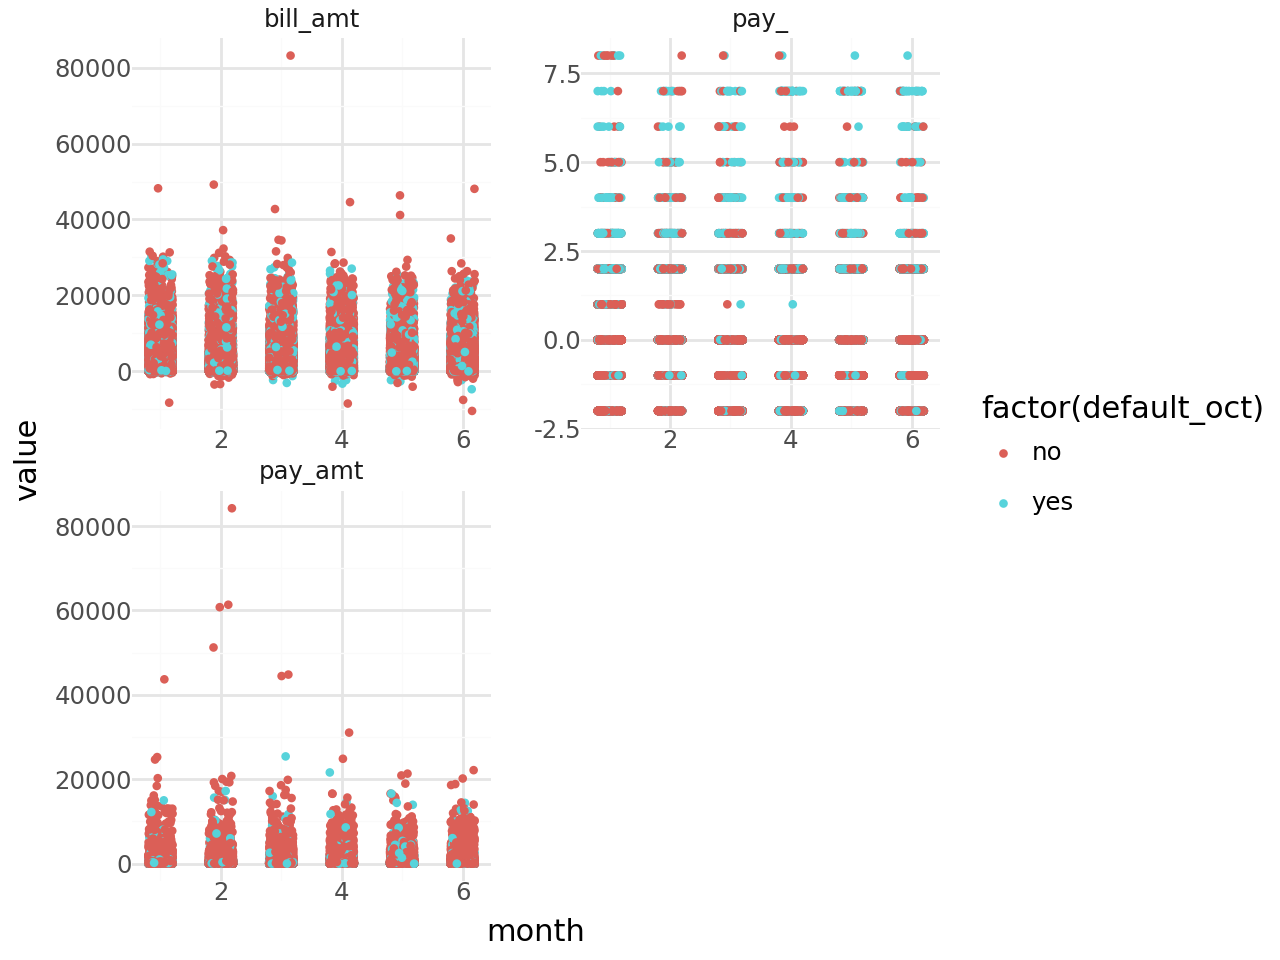

In [8]:
plot_data['month'] = pd.to_numeric(plot_data['month'], errors='coerce')

(pn.ggplot(plot_data, pn.aes(x="month", y="value", color="factor(default_oct)"))
 + pn.geom_jitter(width=0.2,height=0,size=0.75)
 + pn.facet_wrap("~column",ncol=2,scales='free')
 + pn.theme_minimal())

We can see some separation with the payment history.

but there are just too many points to really plot out with trend lines. Outliers are abundant as well.

lets just focus on smooth loess lines.

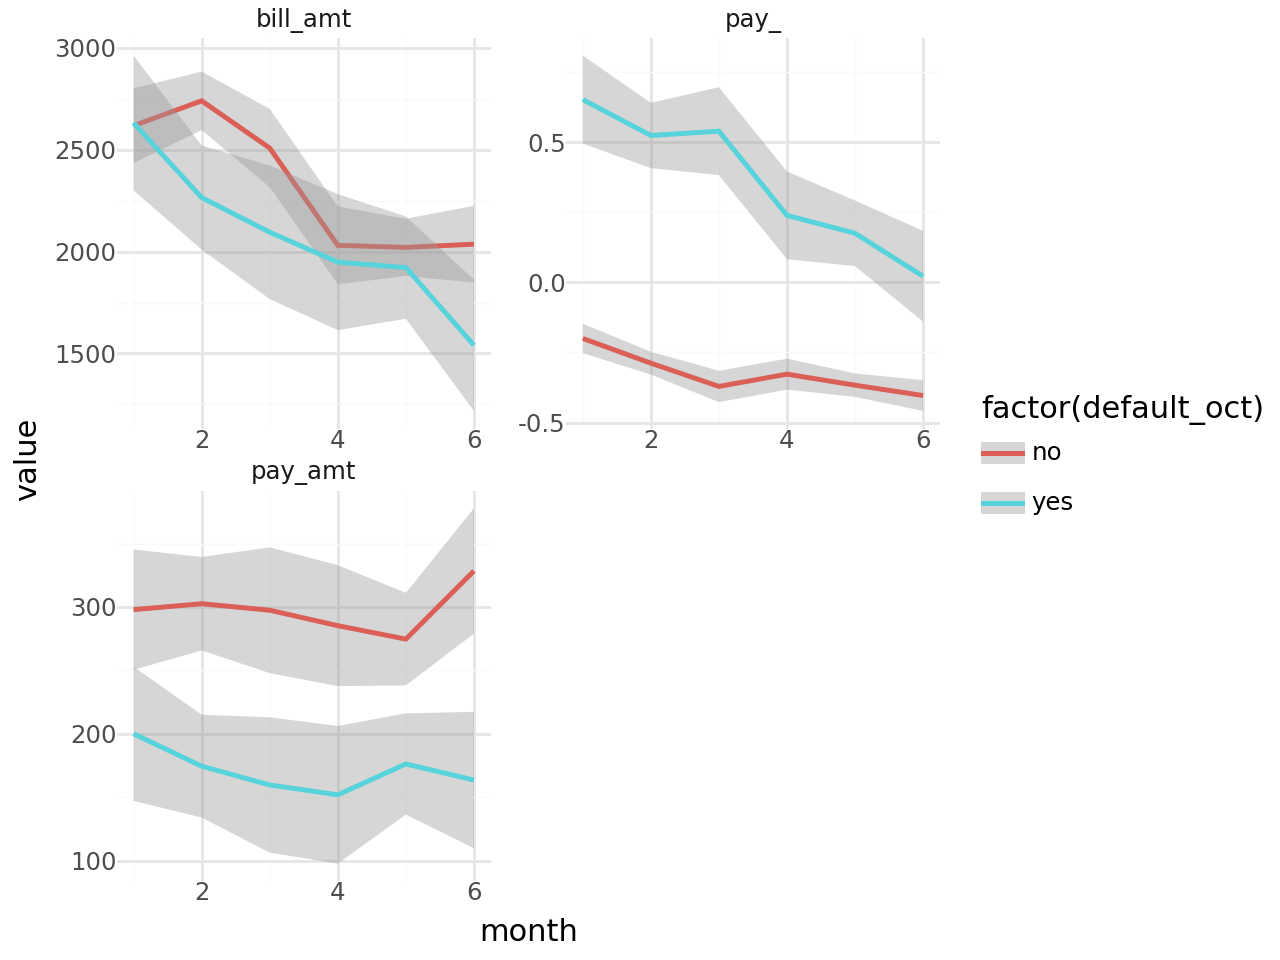

In [9]:
plot_data2 = plot_data.sample(n=30000) # sampling to get around a kernal crash

(pn.ggplot(plot_data2, pn.aes(x="month", y="value", color="factor(default_oct)"))
 + pn.geom_smooth(method="loess")
 + pn.facet_wrap("~column",ncol=2,scales='free')
 + pn.theme_minimal())

Interesting trends!

One of the most obvious is history of past payments (`pay_`). of course we'd expect more defaults with people that dont pay on time.

The other graphs are a little bit less clear. `pay_amt` appears to show that folks that default typicall have lower pay amounts and bill statments. Maybe this is a split of economic statues richer folks tend to spend more and are able to pay their statements off.

Regardless -- without getting into hairy interactions, we can already see more powerful predictors of whether someone defaults or not.

# Next lets focus on education, sex, age, and marriage status

In [10]:
columns_to_extract = ['default_oct','age','sex','education','marriage']
plot_data3 = model_dat[columns_to_extract]

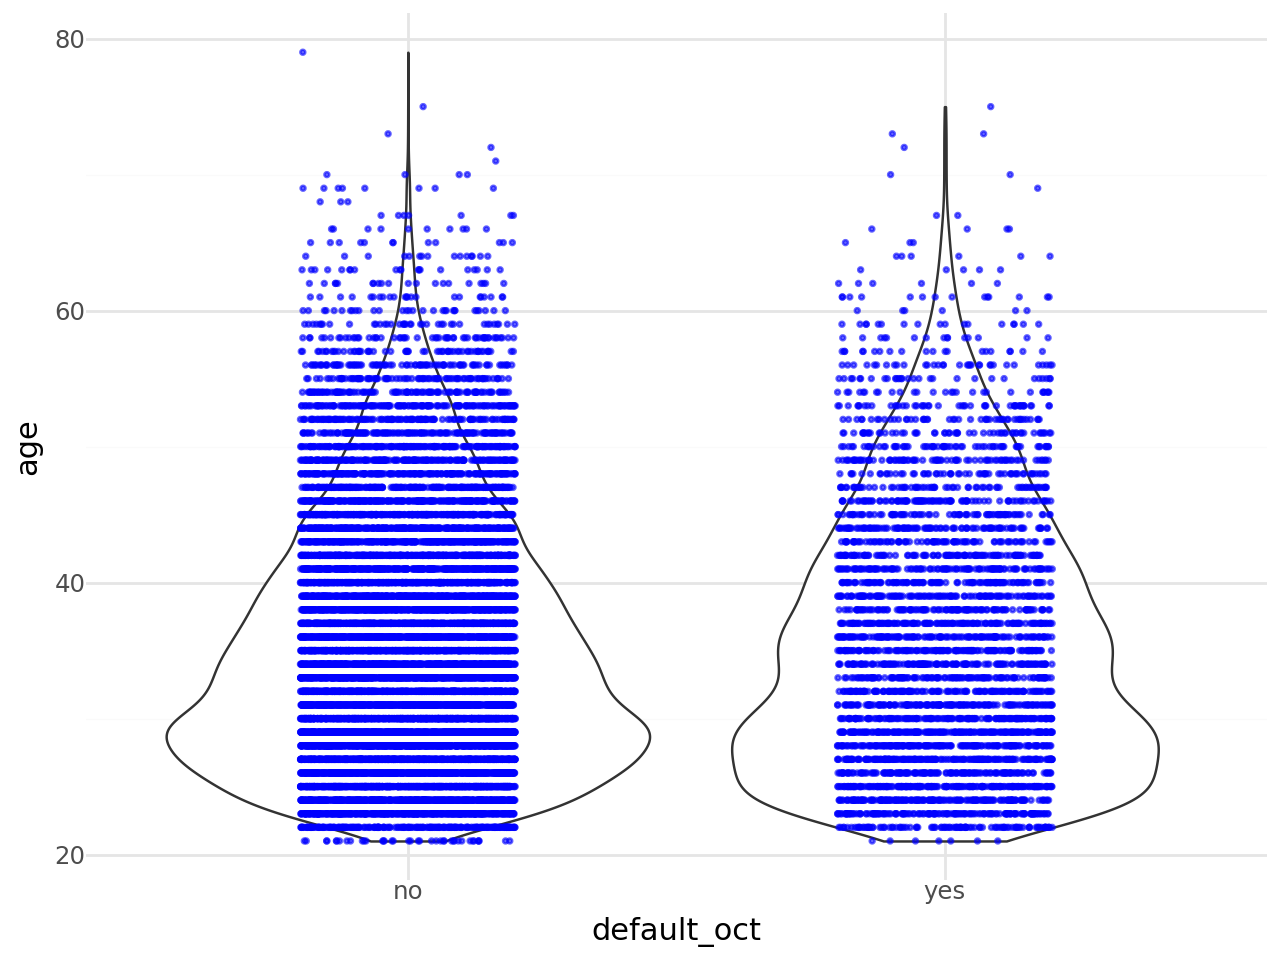

In [11]:
p1 = (pn.ggplot(plot_data3, pn.aes(x="default_oct", y="age"))
 + pn.geom_violin(pn.aes())
 + pn.geom_jitter(width=0.2,height=0,alpha=0.6,size=0.5,color='blue')
 + pn.theme_minimal())

p1

Well age does not look to be a strong indicator....it looks like a older folks are less likely to default.

In [12]:
grouped_df = plot_data3.groupby(['sex', 'education', 'marriage'])['default_oct'].value_counts().unstack(fill_value=0).reset_index()
grouped_df['sex_label'] = grouped_df['sex'].map({1: 'male', 2: 'female'})
grouped_df['education_label'] = grouped_df['education'].map({1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others'})
grouped_df['marriage_label'] = grouped_df['marriage'].map({1: 'married', 2: 'single', 3: 'others'})

grouped_df

default_oct,sex,education,marriage,no,yes,sex_label,education_label,marriage_label
0,1.0,0.0,1.0,1,0,male,NaN,married
1,1.0,0.0,2.0,4,0,male,NaN,single
2,1.0,1.0,0.0,1,0,male,graduate school,NaN
3,1.0,1.0,1.0,837,249,male,graduate school,married
4,1.0,1.0,2.0,1381,307,male,graduate school,single
5,1.0,1.0,3.0,12,5,male,graduate school,others
6,1.0,2.0,1.0,1101,390,male,university,married
7,1.0,2.0,2.0,1417,483,male,university,single
8,1.0,2.0,3.0,29,10,male,university,others
9,1.0,3.0,0.0,6,1,male,high school,NaN


okay the education column has 0-6 whereas the instructions say that there should only be 1-4.

Marriage also includes 0. I will remove theses

I will remove these assuming this is an error.

In [13]:
grouped_df2 = grouped_df[(grouped_df['education'] >= 1) & (grouped_df['education'] <= 4) & (grouped_df['marriage'] > 0)]
grouped_df2['marrage_sex'] = grouped_df2['marriage_label'].astype(str) + "_" + grouped_df2['sex_label']
grouped_df2

/tmp/ipykernel_432002/3793072385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


default_oct,sex,education,marriage,no,yes,sex_label,education_label,marriage_label,marrage_sex
3,1.0,1.0,1.0,837,249,male,graduate school,married,married_male
4,1.0,1.0,2.0,1381,307,male,graduate school,single,single_male
5,1.0,1.0,3.0,12,5,male,graduate school,others,others_male
6,1.0,2.0,1.0,1101,390,male,university,married,married_male
7,1.0,2.0,2.0,1417,483,male,university,single,single_male
8,1.0,2.0,3.0,29,10,male,university,others,others_male
10,1.0,3.0,1.0,477,193,male,high school,married,married_male
11,1.0,3.0,2.0,408,144,male,high school,single,single_male
12,1.0,3.0,3.0,16,5,male,high school,others,others_male
13,1.0,4.0,1.0,8,2,male,others,married,married_male


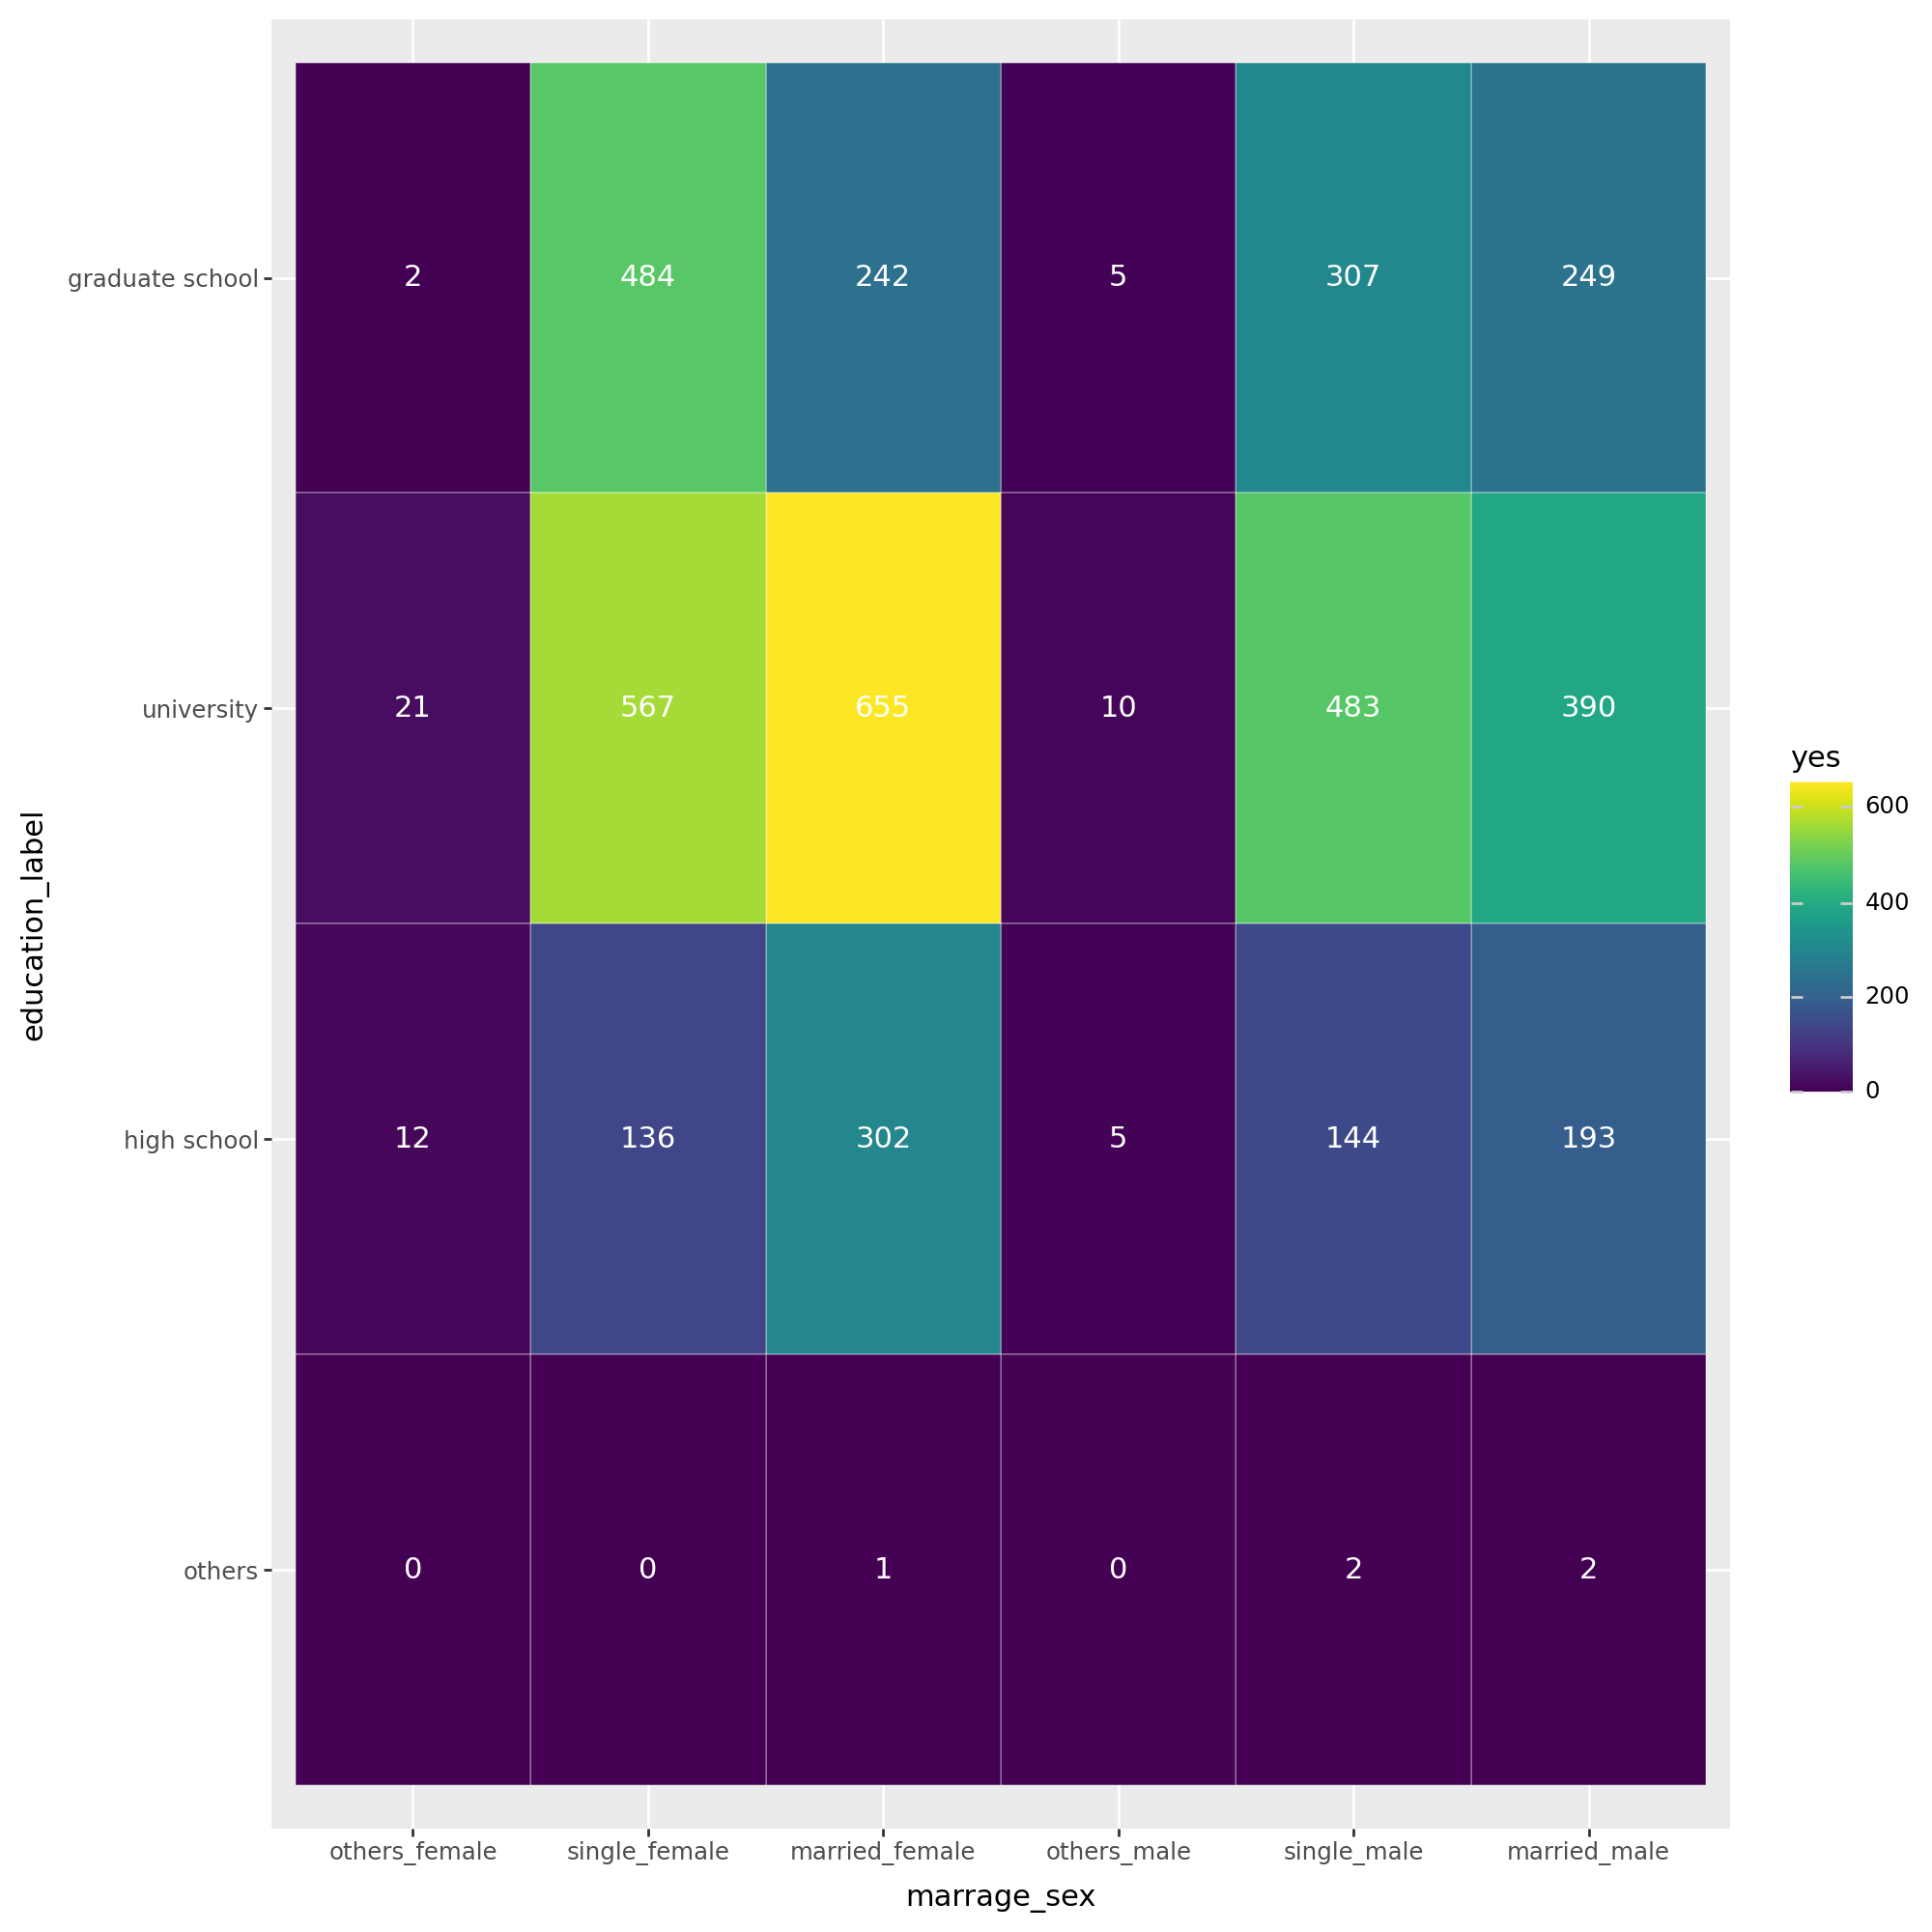

In [14]:


(pn.ggplot(grouped_df2, pn.aes(y="education_label", x="marrage_sex", fill="yes"))
 + pn.geom_tile(color='white')
 + pn.geom_text(pn.aes(label="yes"),color='white')
 + pn.theme(figure_size=(10, 10))
 + pn.scale_y_discrete(limits=["others","high school", "university", "graduate school"])
 + pn.scale_x_discrete(limits=["others_female","single_female","married_female","others_male","single_male","married_male"]))

So we can start to see a trend here. across the board theres not a lot happening in the 'others' categories. Interestingly, it appears to be the university educated folks defaulting more often. A biased towards married females too.

Im worried that this might be a sample bias. For example if there are more females overall in the dataset, that will make university educated married females appear to default more often.

lets make a graph to show percentage of defaults of total counts

/tmp/ipykernel_432002/3202702485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_432002/3202702485.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


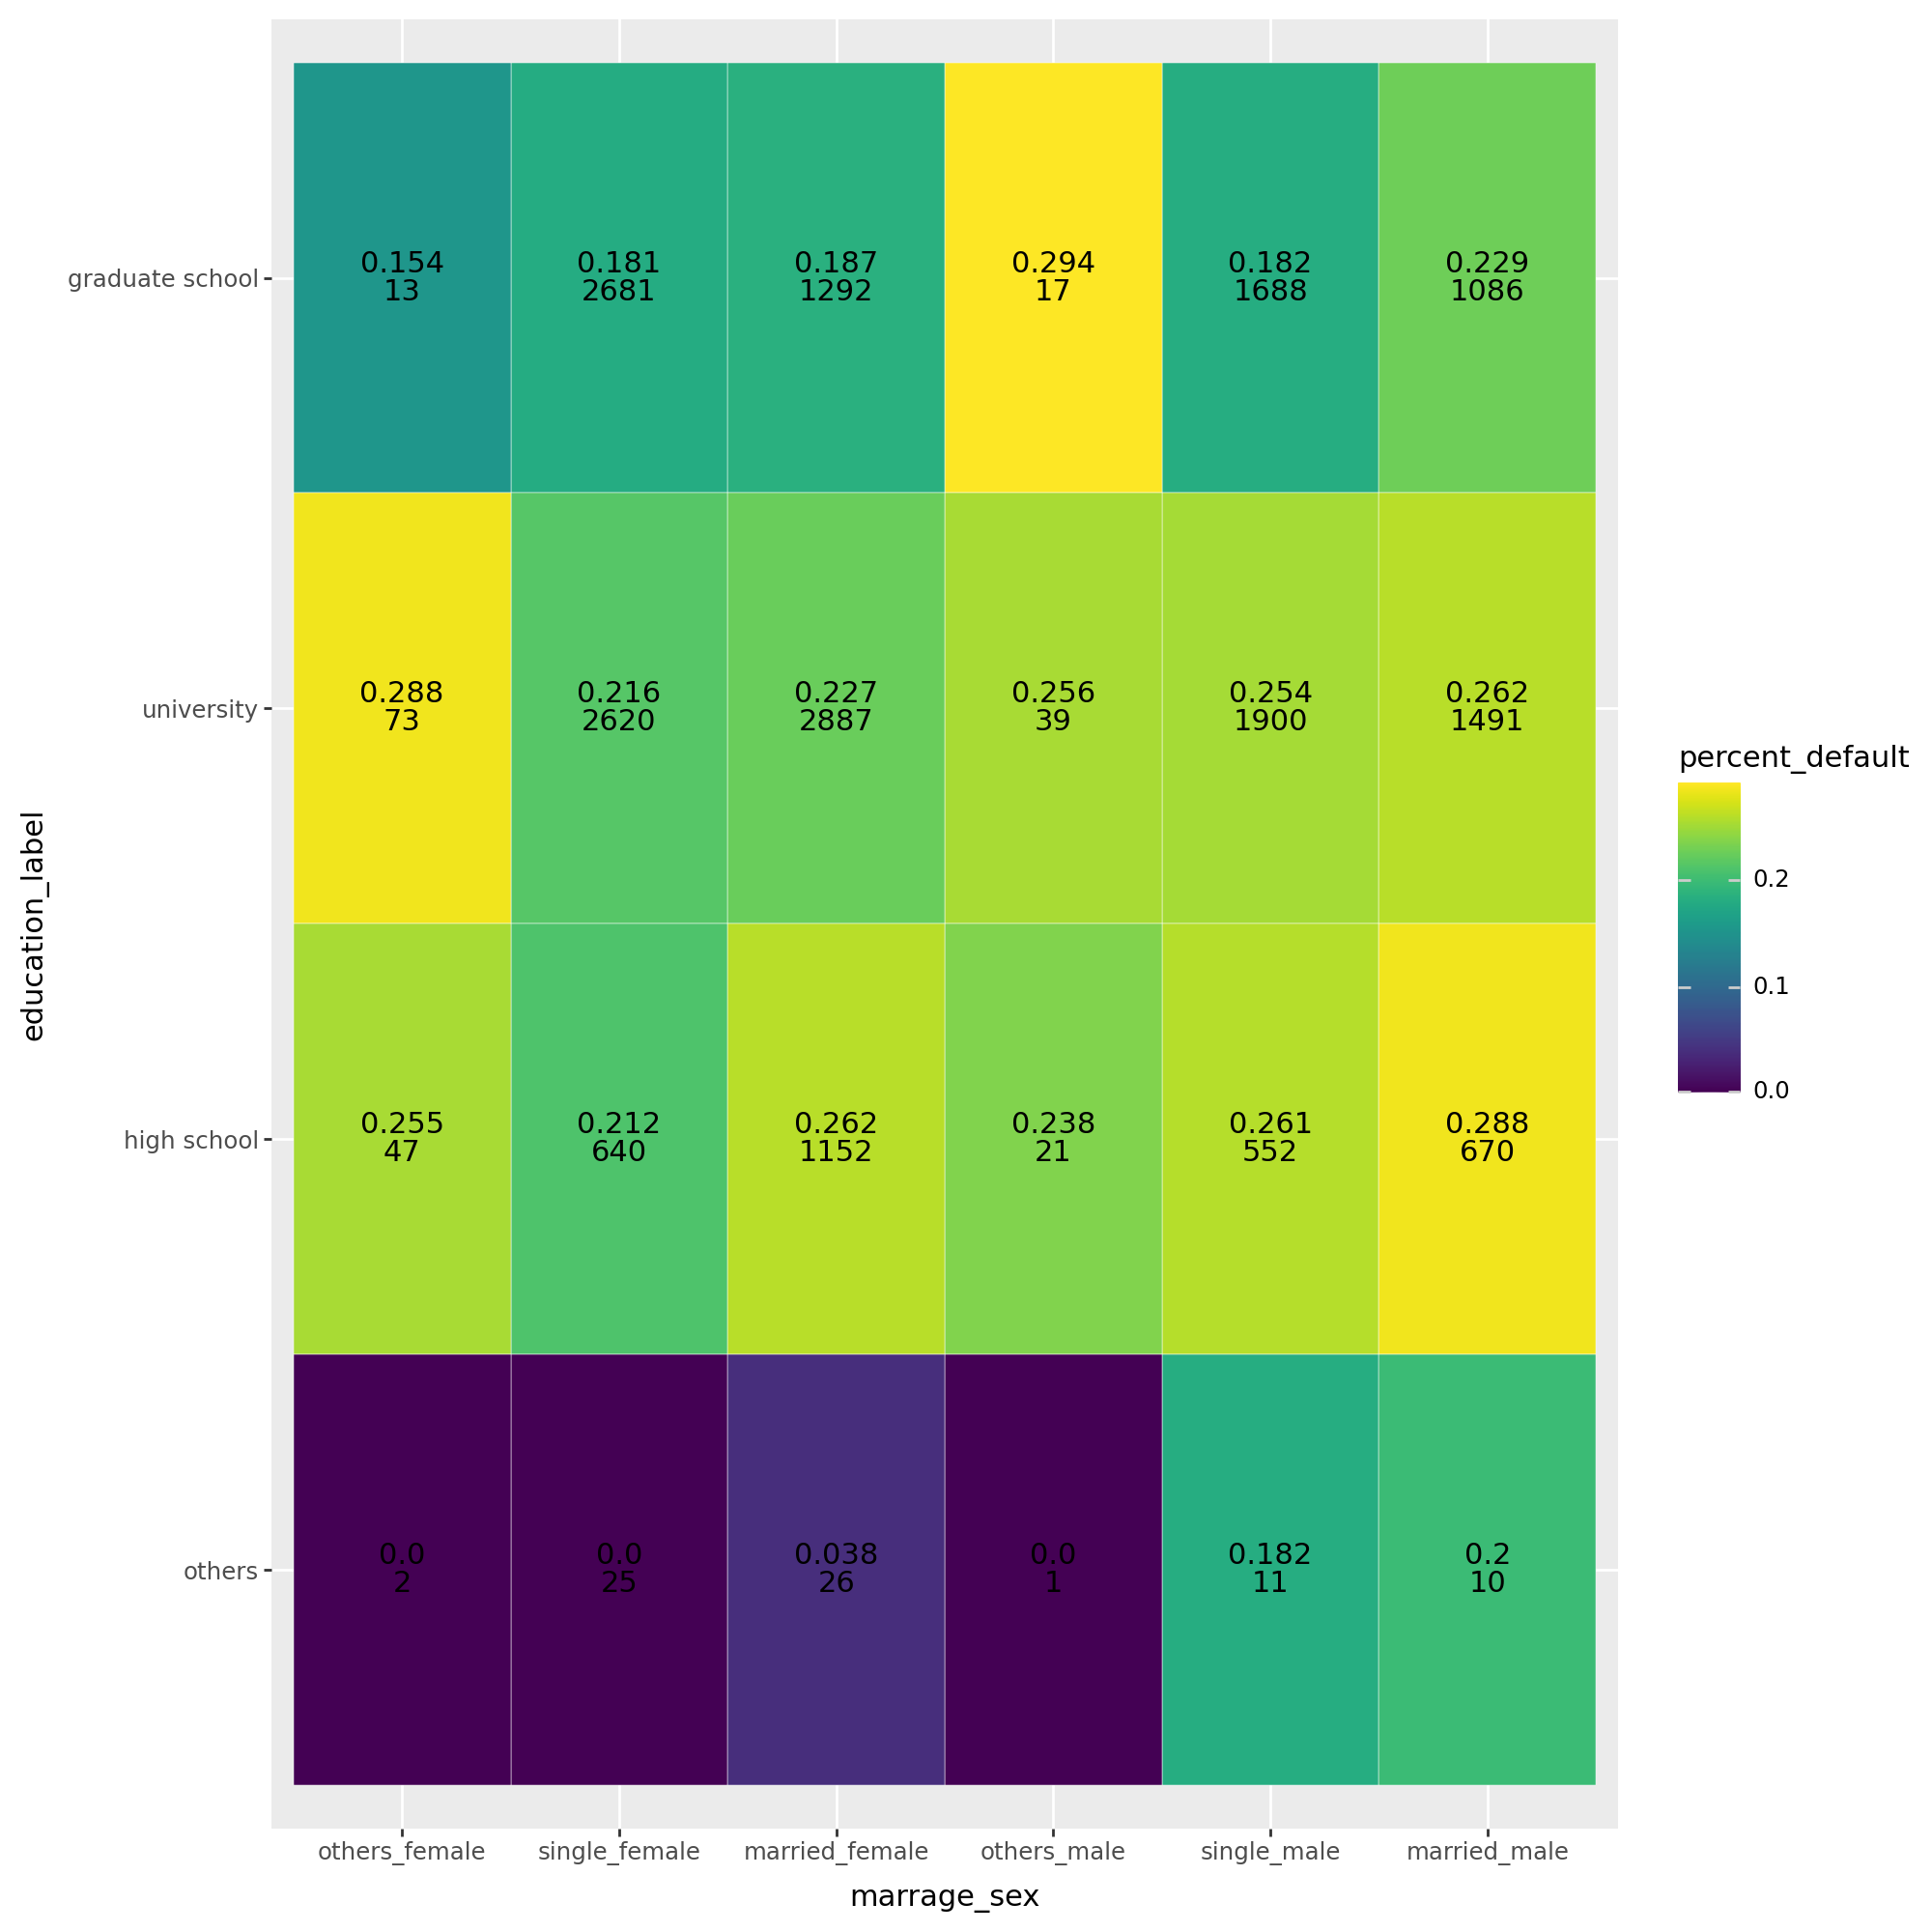

In [15]:
grouped_df2['total'] = (grouped_df2['yes'] + grouped_df2['no'])
grouped_df2['percent_default'] = (grouped_df2['yes'] / (grouped_df2['total'])).round(3)


(pn.ggplot(grouped_df2, pn.aes(y="education_label", x="marrage_sex", fill="percent_default"))
 + pn.geom_tile(color='white')
 + pn.geom_text(pn.aes(label="percent_default"),color='black',va='bottom')
 + pn.geom_text(pn.aes(label="total"),color='black',va='top')
 + pn.theme(figure_size=(10, 10))
 + pn.scale_y_discrete(limits=["others", "high school", "university", "graduate school"])
 + pn.scale_x_discrete(limits=["others_female", "single_female", "married_female", "others_male", "single_male", "married_male"]))

now we can see ratios of number of defaults of the total population. Ratios are tricky becuase it masks sample sizes. For example `others` and `married_male` has a 20% default with only 10 samples. We are less confident about that as compared to `university` and `married_female`. Just a lot more representation!

This just shows how we can draw erronuous conclusions with how we play around with the data



before I forget, let look at the number of NAs overall:

In [16]:
na_count = model_dat.isna().sum()

# Total number of NaN values in the entire DataFrame
total_na_count = model_dat.isna().sum().sum()
na_rows_count = model_dat.isna().any(axis=1).sum()



print("Number of NaN values in each column:")
print(na_count)

print("\nTotal number of NaN values in the DataFrame:", total_na_count)
print("Total number of rows with at least one NaN value:", na_rows_count)
print("\nTotal number of rows in the DataFrame:", len(model_dat))

Number of NaN values in each column:
customer_id      0
limit_bal        0
sex              0
education        0
marriage         0
age              0
pay_1            0
pay_2            0
pay_3            0
pay_4            0
pay_5          148
pay_6          983
bill_amt1        0
bill_amt2        0
bill_amt3        0
bill_amt4        0
bill_amt5      148
bill_amt6      983
pay_amt1         0
pay_amt2         0
pay_amt3         0
pay_amt4         0
pay_amt5       148
pay_amt6       983
default_oct      0
dtype: int64

Total number of NaN values in the DataFrame: 3393
Total number of rows with at least one NaN value: 983

Total number of rows in the DataFrame: 19201


So the total number of rows with NA is 974. This is only in the time series columns specificaly may and april. This doesnt seem like a lot of data to worry about given the dataset

# Data exploration conclusions

I could keep on going down this road and figure out interesting relationships between the predictors and the target. Some conclusions:

* obviously number of missed payments is a critical factor.
* bill amount and pay amount look to have separation but I wonder have this pans out with the interaction between `sex,marriage,education`
* it appears that graduate educated folks have less defaults than high school and university
* I didnt see big trends in age, sex, and marriage status but these factors my be super important in an interaction...
* there are only a few NAs in the dataset compared to the overall dataset. First pass, i'll simply drop them.

I think I know enough to start modeling and see what sort of accuracy we can get with a model.

# Modeling 
Lets adjust `model_dat` for the errors we caught in the data exploration stage. I will also assess NAs to see whether I just drop them or do some fun imputation...

I will limit this 6 different model approaches:

* logistic regression
* random forest
* xgbost
* support vector machine
* ensemble model (voting average between the top three)
* model stacking (using random forest, xgboost, and linear regression)

Lets remove the erroneous data:

In [17]:
model_dat2 = model_dat[(model_dat['education'] >= 1) & (model_dat['education'] <= 4) & (model_dat['marriage'] > 0)] \
    .dropna()

model_dat2.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,17970.0,NaN,NaN,NaN,11945.914135,6932.448915,1.0,5961.5,11909.5,17937.75,24000.0
limit_bal,17970.0,NaN,NaN,NaN,8348.636617,6458.544678,500.0,2500.0,7000.0,12000.0,50000.0
sex,17970.0,NaN,NaN,NaN,1.605954,0.488658,1.0,1.0,2.0,2.0,2.0
education,17970.0,NaN,NaN,NaN,1.811909,0.708277,1.0,1.0,2.0,2.0,4.0
marriage,17970.0,NaN,NaN,NaN,1.556817,0.518804,1.0,1.0,2.0,2.0,3.0
age,17970.0,NaN,NaN,NaN,35.36611,9.163665,21.0,28.0,34.0,41.0,75.0
pay_1,17970.0,NaN,NaN,NaN,-0.015804,1.127705,-2.0,-1.0,0.0,0.0,8.0
pay_2,17970.0,NaN,NaN,NaN,-0.135058,1.201897,-2.0,-1.0,0.0,0.0,8.0
pay_3,17970.0,NaN,NaN,NaN,-0.165554,1.202666,-2.0,-1.0,0.0,0.0,8.0
pay_4,17970.0,NaN,NaN,NaN,-0.213467,1.18078,-2.0,-1.0,0.0,0.0,8.0


Lets define a data preprocessing step and preprocess the data for modeling

In [18]:
def preprocess_data(data):
    data.dropna(inplace=True)
    X = data.drop(['default_oct', 'customer_id'], axis=1)
    y = data['default_oct']
    le = LabelEncoder()
    y = le.fit_transform(y)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Preprocessing
X, y = preprocess_data(model_dat2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Now for hyperparam tuning

In [19]:



# Define models and parameter grids
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'solver': ['liblinear', 'lbfgs']
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'SVC': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }
}

# Hyperparameter tuning with parallelization and progress bar
def tune_model(name, model, param_grid, X_train, y_train):
    print(f"Tuning {name}...")
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    return name, grid_search.best_estimator_

print("Tuning models...")
tuned_models = Parallel(n_jobs=-1)(
    delayed(tune_model)(name, model, param_grids[name], X_train, y_train)
    for name, model in tqdm(models.items(), desc="Model Tuning")
)

# Store the best models
best_models = {name: model for name, model in tuned_models}


Tuning models...


Model Tuning: 100%|██████████| 5/5 [00:00<00:00, 124.22it/s]


Tuning KNN...
Best parameters for KNN: {'n_neighbors': 7, 'weights': 'uniform'}
Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


Lets evaluate the models

In [20]:

# Evaluate models in parallel 
def evaluate_model(name, model, X_test, y_test):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    logloss = log_loss(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model_name': name,
        'model': model,
        'log_loss': logloss,
        'auc': auc,
        'confusion_matrix': cm
    }

print("Evaluating models...")
tuned_results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(name, model, X_test, y_test)
    for name, model in tqdm(best_models.items(), desc="Model Evaluation")
)



Evaluating models...


Model Evaluation: 100%|██████████| 5/5 [00:00<00:00, 2562.19it/s]


Now an ensemble modeling approach with the tuned models

In [21]:
# Ensemble modeling with tuned models
print("Training ensemble model...")
ensemble = VotingClassifier(estimators=[
    ('lr', best_models['Logistic Regression']), 
    ('rf', best_models['Random Forest']), 
    ('xgb', best_models['XGBoost']), 
    ('svc', best_models['SVC']), 
    ('knn', best_models['KNN'])], voting='soft', n_jobs=-1)

ensemble.fit(X_train, y_train)
tuned_results.append(evaluate_model('Ensemble', ensemble, X_test, y_test))



Training ensemble model...


Lastly a stacked model with the tuned models

In [22]:
# Model stacking with tuned models
print("Training stacking model...")
stacking = StackingClassifier(
    estimators=[
        ('lr', best_models['Logistic Regression']),
        ('rf', best_models['Random Forest']),
        ('xgb', best_models['XGBoost']),
        ('svc', best_models['SVC']),
        ('knn', best_models['KNN'])
    ],
    final_estimator=LogisticRegression(), n_jobs=-1
)

stacking.fit(X_train, y_train)
tuned_results.append(evaluate_model('Stacking', stacking, X_test, y_test))


Training stacking model...


Lets evaluate how well they preform:

In [23]:

# Display tuned results
for result in tuned_results:
    print(f"Model: {result['model_name']}")
    print(f"Log Loss: {result['log_loss']}")
    print(f"AUC: {result['auc']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")
    print("-" * 30)

# Store tuned results in a DataFrame for comparison
tuned_results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Log Loss': r['log_loss'],
    'AUC': r['auc'],
    'Confusion Matrix': r['confusion_matrix']
} for r in tuned_results])


Model: Logistic Regression
Log Loss: 0.4790334865723914
AUC: 0.7195561609973162
Confusion Matrix:
[[4055  112]
 [ 965  259]]
------------------------------
Model: Random Forest
Log Loss: 0.4374134737946857
AUC: 0.7773668302614223
Confusion Matrix:
[[3968  199]
 [ 806  418]]
------------------------------
Model: XGBoost
Log Loss: 0.4399219343010534
AUC: 0.7743582474186379
Confusion Matrix:
[[3961  206]
 [ 809  415]]
------------------------------
Model: SVC
Log Loss: 0.4727236932156064
AUC: 0.7135514452961411
Confusion Matrix:
[[4034  133]
 [ 926  298]]
------------------------------
Model: KNN
Log Loss: 1.6759797603203082
AUC: 0.7061987001824168
Confusion Matrix:
[[3902  265]
 [ 841  383]]
------------------------------
Model: Ensemble
Log Loss: 0.4461503142238475
AUC: 0.7664100597442401
Confusion Matrix:
[[3992  175]
 [ 860  364]]
------------------------------
Model: Stacking
Log Loss: 0.4394314948533737
AUC: 0.7767921703518621
Confusion Matrix:
[[3959  208]
 [ 795  429]]
-----------

#### overall thoughts

It definitely appears that a random forest or the stacking type model are the best models to go with. I suspect the stacking modeling performs just as good as the random forest simply because it contains a random forest.

I am inclined to continue with the random forest alogrithm.

Here are some summaries: 

#### Key Metrics
1. **Recall (True Positive Rate)**:
 - **Random Forest**: 0.338
 - **Stacking**: 0.350  
 *Stacking has a slightly higher recall, indicating better performance in identifying positive cases.*

2. **False Positive Rate**:
 - **Random Forest**: 0.046
 - **Stacking**: 0.050  
 *Random Forest has a lower false positive rate, making fewer incorrect positive predictions.*

3. **Precision**:
 - **Random Forest**: 0.681
 - **Stacking**: 0.674  
 *Random Forest has marginally higher precision, meaning its positive predictions are slightly more accurate.*

#### Conclusion
- Both **Random Forest** and **Stacking** perform similarly overall.
- **Random Forest** has a slight edge in minimizing false positives, making it preferable if the cost of false positives is high.
- **Stacking** achieves better recall, making it a better choice if identifying as many true positives as possible is the main goal.


All of this depends on the specific use case:

- Choose **Random Forest** if reducing false positives is critical.
- Choose **Stacking** if maximizing recall is more important.


Lets see how these models perform of the global test set:

In [24]:
# Preprocessing the final test split
X_final_test, y_final_test = preprocess_data(ground_truth_data_split)

# Evaluate all models on the final test set
print("Evaluating models on the final test set...")
final_results = Parallel(n_jobs=-1)(
    delayed(evaluate_model)(name, model, X_final_test, y_final_test)
    for name, model in tqdm(best_models.items(), desc="Final Test Set Evaluation")
)

# Evaluate the ensemble model
final_results.append(evaluate_model('Ensemble', ensemble, X_final_test, y_final_test))

# Evaluate the stacking model
final_results.append(evaluate_model('Stacking', stacking, X_final_test, y_final_test))


# Store final results in a DataFrame for comparison
final_results_df = pd.DataFrame([{
    'Model': r['model_name'],
    'Log Loss': r['log_loss'],
    'AUC': r['auc'],
    'Confusion Matrix': r['confusion_matrix']
} for r in final_results])


Evaluating models on the final test set...


Final Test Set Evaluation: 100%|██████████| 5/5 [00:00<00:00, 1979.57it/s]


In [27]:

# Display the final DataFrame
final_results_df.sort_values(by='Log Loss', ascending=True)


,Model,Log Loss,AUC,Confusion Matrix
6,Stacking,0.442875,0.762424,"[[3391, 156], [701, 324]]"
1,Random Forest,0.443318,0.761554,"[[3376, 171], [674, 351]]"
2,XGBoost,0.445769,0.759540,"[[3426, 121], [747, 278]]"
5,Ensemble,0.447676,0.757369,"[[3407, 140], [720, 305]]"
3,SVC,0.468030,0.720158,"[[3425, 122], [757, 268]]"
0,Logistic Regression,0.473240,0.716621,"[[3459, 88], [777, 248]]"
4,KNN,1.674446,0.702562,"[[3306, 241], [708, 317]]"


As suggested by cross validation the stack and random forest models really dominated the prediction accuracy. I think the final model to use in this case should be the random forest. It is more simplistic and can be more intrepetable than the model stack option.


Lets predict onto the given test set and use the given function to write out the submission to csv

In [36]:
def make_submission(name, data_frame):
    """
    Parameters:
    -----------
        name:               string, your name
        data_frame:         pandas DataFrame [5999, 2], customer ids and 
                                predicted probabilities on the test set
    """
    cnames = data_frame.columns.values
    if not isinstance(data_frame, pd.DataFrame):
        raise ValueError('Expecting a pandas DataFrame for argument 2')
    elif cnames[0] != 'customer_id':
        raise ValueError('Column name 0 incorrect, expecting customer_id, received ' + cnames[0])
        
    t0 = time()
    
    # Set the filename to the project root
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
    filename = os.path.join(project_root, name + '.csv')
    
    data_frame.to_csv(filename, index=False)
    return '{fname} written in {t:.{rd}f} ms'.format(fname=filename, t=(time() - t0) / 1000., rd=3)


# Load the test dataset
test_data_path = os.path.abspath('../data/Douglas Lawton- DS Case Study/test.csv')
test_data = pd.read_csv(test_data_path)

# Preprocess the test dataset
def preprocess_data(data):
    data.dropna(inplace=True)
    X = data.drop(['default_oct', 'customer_id'], axis=1, errors='ignore')  # Ignore if not present
    y = data.get('default_oct')
    if y is not None:
        le = LabelEncoder()
        y = le.fit_transform(y)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

# Preprocess the test data
X_test, _ = preprocess_data(test_data)

# Predict using the Random Forest model
# Assuming random_forest_model has already been trained as per previous steps
random_forest_model = best_models['Random Forest']  # Make sure best_models dictionary is available
predictions_prob = random_forest_model.predict_proba(X_test)[:, 1]

# Prepare the DataFrame for submission
submission_df = pd.DataFrame({
    'customer_id': test_data['customer_id'],
    'predicted_probability': predictions_prob
})

# Create the submission file
result = make_submission('douglas_lawton', submission_df)

# Display the result
print(result)

/home/datascience/red_venutres_take_home 3/douglas_lawton.csv written in 0.000 ms
